# Sites generalization results analysis

### This file handles the results of the sites generalization results done in `run_experiments.ipynb` (site-specific and leave one site out), and generates the table seen in the paper


In [1]:
from dotenv import load_dotenv
from pathlib import Path
import sys
import os

# Walk up until we find the project root (folder with the .env)
current_path = Path().resolve()
for parent in [current_path] + list(current_path.parents):
    if (parent / ".env").exists():
        load_dotenv(parent / ".env")
        project_root = os.getenv("PROJECT_ROOT")
        print(project_root)
        sys.path.append(project_root)     
        break


%load_ext autoreload
%autoreload 2

/Users/emmanuel/Documents/belugas/beluga-call-pipeline


In [2]:

import os
import json
import pandas as pd

In [4]:
results_dir = "../results/sites_generalization"
runs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
leave_one_out_runs = [run for run in runs if "out" in run]


In [ ]:

sites = ["BSM", "CAC", "KAM", "RDL"]

# Load cross validation results for each run
results = {}
for run in runs:
    res_obj = {}
    results_path = os.path.join(results_dir, run, "cross_val_test_results.json")
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            res_obj["metrics_dict"] =json.load(f)

    results[run] = res_obj
    



In [11]:
import pandas as pd

# Build a summary table for leave-one-out results
rows = []
for run in results:
    for site in sites:
        metrics_dict = results[run]["metrics_dict"]["other_tests"]
        

        row = {
            "run": run,
            "site": site,
            "F1 Score Macro": f"{metrics_dict[site]['f1']['Labels_Average']["mean"]:.3f}",
            "ECHO F1": f"{metrics_dict[site]['f1']['ECHO']["mean"]:.3f}",
            "CC F1": f"{metrics_dict[site]['f1']['CC']["mean"]:.3f}",
            "HFPC F1": f"{metrics_dict[site]['f1']['HFPC']["mean"]:.3f}",
            "Whistle F1": f"{metrics_dict[site]['f1']['Whistle']["mean"]:.3f}",

            "Precision Macro": f"{metrics_dict[site]['precision']['Labels_Average']["mean"]:.3f}",
            "ECHO Precision": f"{metrics_dict[site]['precision']['ECHO']["mean"]:.3f}", 
            "CC Precision": f"{metrics_dict[site]['precision']['CC']["mean"]:.3f}",
            "HFPC Precision": f"{metrics_dict[site]['precision']['HFPC']["mean"]:.3f}",
            "Whistle Precision": f"{metrics_dict[site]['precision']['Whistle']["mean"]:.3f}",

            "Recall Macro": f"{metrics_dict[site]['recall']['Labels_Average']["mean"]:.3f}",
            "ECHO Recall": f"{metrics_dict[site]['recall']['ECHO']["mean"]:.3f}",
            "CC Recall": f"{metrics_dict[site]['recall']['CC']["mean"]:.3f}", 
            "HFPC Recall": f"{metrics_dict[site]['recall']['HFPC']["mean"]:.3f}",
            "Whistle Recall": f"{metrics_dict[site]['recall']['Whistle']["mean"]:.3f}",
        }

        rows.append(row)

        # if run.endswith("_qat"):
        if "_qat" in run:
            test_key = site +"_quantized"
            
            quantized_row = {
                "run": run + "_8bit",
                "site": site,
                "F1 Score Macro": f"{metrics_dict[test_key]['f1']['Labels_Average']["mean"]:.3f}",
                "ECHO F1": f"{metrics_dict[test_key]['f1']['ECHO']["mean"]:.3f}",
                "CC F1": f"{metrics_dict[test_key]['f1']['CC']["mean"]:.3f}",
                "HFPC F1": f"{metrics_dict[test_key]['f1']['HFPC']["mean"]:.3f}",
                "Whistle F1": f"{metrics_dict[test_key]['f1']['Whistle']["mean"]:.3f}",

                "Precision Macro": f"{metrics_dict[test_key]['precision']['Labels_Average']["mean"]:.3f}",
                "ECHO Precision": f"{metrics_dict[test_key]['precision']['ECHO']["mean"]:.3f}", 
                "CC Precision": f"{metrics_dict[test_key]['precision']['CC']["mean"]:.3f}",
                "HFPC Precision": f"{metrics_dict[test_key]['precision']['HFPC']["mean"]:.3f}",
                "Whistle Precision": f"{metrics_dict[test_key]['precision']['Whistle']["mean"]:.3f}",

                "Recall Macro": f"{metrics_dict[test_key]['recall']['Labels_Average']["mean"]:.3f}",
                "ECHO Recall": f"{metrics_dict[test_key]['recall']['ECHO']["mean"]:.3f}",
                "CC Recall": f"{metrics_dict[test_key]['recall']['CC']["mean"]:.3f}", 
                "HFPC Recall": f"{metrics_dict[test_key]['recall']['HFPC']["mean"]:.3f}",
                "Whistle Recall": f"{metrics_dict[test_key]['recall']['Whistle']["mean"]:.3f}",
            }

            rows.append(quantized_row)
            



generalization_df = pd.DataFrame(rows)

In [22]:
# Step 1: Create pivot and reset index
table = generalization_df.pivot(index='run', columns='site', values='F1 Score Macro').reset_index()
table_filtered = table[~table["run"].str.contains("include")]
table.head(5)

site,run,BSM,CAC,KAM,RDL
0,All_sites,0.925,0.923,0.921,0.912
1,All_sites_qat,0.924,0.923,0.924,0.907
2,All_sites_qat_8bit,0.921,0.926,0.918,0.907
3,BSM_only,0.896,0.739,0.752,0.762
4,BSM_only_qat,0.893,0.737,0.751,0.757


In [13]:
import pandas as pd

base_runs = table_filtered['run'].str.replace(r'(_qat_8bit|_qat)$', '', regex=True).unique()
sites = ['BSM', 'CAC', 'KAM', 'RDL']

def get_val(run_base, site, suffix, table):
    full_run = run_base + suffix
    match = table[table['run'] == full_run]
    if not match.empty:
        val = match[site].values[0]
        try:
            return float(val)
        except (ValueError, TypeError):
            return 0.0
    else:
        return 0.0

def generate_final_table(generalization_df, setting):
    table = generalization_df.pivot(index='run', columns='site', values='F1 Score Macro').reset_index()
    table_filtered = table[~table["run"].str.contains("include")]

    base_runs = table_filtered['run'].str.replace(r'(_qat_8bit|_qat)$', '', regex=True).unique()

    # Step 2: Build summary
    summary_rows = []
    for base in base_runs:
        row = {'run': base}
        fp_gaps = []
        qat_gaps = []

        for site in sites:
            fp_val = get_val(base, site, '', table_filtered)
            qat_val = get_val(base, site, '_qat_8bit', table_filtered)
            if setting == "show_both":   
                row[site] = f"{fp_val:.2f} / {qat_val:.2f}"
            elif setting == "qat_only":
                row[site] = f"{qat_val:.2f}"
            else :
                row[site] = f"{fp_val:.2f}"
            

        # Compute generalization gap
        if base == 'All_sites':
            row['Gen. Gap'] = '–'
        elif 'only' in base:
            site_trained = base.split('_')[0].upper()
            other_sites = [s for s in sites if s != site_trained]
            for test_site in other_sites:
                model_fp = get_val(base, test_site, '', table_filtered)
                best_fp = get_val(f"{test_site}_only", test_site, '', table_filtered)
                fp_gaps.append(best_fp - model_fp)

                model_qat = get_val(base, test_site, '_qat_8bit', table_filtered)
                best_qat = get_val(f"{test_site}_only", test_site, '_qat_8bit', table_filtered)
                qat_gaps.append(best_qat - model_qat)

            avg_fp_gap = round(sum(fp_gaps) / len(fp_gaps), 2)
            avg_qat_gap = round(sum(qat_gaps) / len(qat_gaps), 2)
            row['Gen. Gap'] = f"{avg_fp_gap:.2f} / {avg_qat_gap:.2f}"

            if setting == "show_both":   
                row['Gen. Gap'] = f"{avg_fp_gap:.2f} / {avg_qat_gap:.2f}"
            elif setting == "qat_only":
                row['Gen. Gap'] = f"{avg_qat_gap:.2f}"
            else :
                row['Gen. Gap'] = f"{avg_fp_gap:.2f}"

        elif 'leave' in base:
            site_left_out = base.split('_')[1].upper()
            fp_all = get_val('All_sites', site_left_out, '', table_filtered)
            fp_model = get_val(base, site_left_out, '', table_filtered)
            qat_all = get_val('All_sites', site_left_out, '_qat_8bit', table_filtered)
            qat_model = get_val(base, site_left_out, '_qat_8bit', table_filtered)

            fp_gap = round(fp_all - fp_model, 2)
            qat_gap = round(qat_all - qat_model, 2)
            row['Gen. Gap'] = f"{fp_gap:.2f} / {qat_gap:.2f}"
            if setting == "show_both":   
                row['Gen. Gap'] = f"{fp_gap:.2f} / {qat_gap:.2f}"
            elif setting == "qat_only":
                row['Gen. Gap'] = f"{qat_gap:.2f}"
            else :
                row['Gen. Gap'] = f"{fp_gap:.2f}"

        else:
            row['Gen. Gap'] = '–'

        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows)
    return summary_df


In [14]:
generate_final_table(generalization_df, setting="show_both")

,run,BSM,CAC,KAM,RDL,Gen. Gap
0,All_sites,0.93 / 0.92,0.92 / 0.93,0.92 / 0.92,0.91 / 0.91,–
1,BSM_only,0.90 / 0.88,0.74 / 0.71,0.75 / 0.74,0.76 / 0.75,0.14 / 0.15
2,CAC_only,0.80 / 0.80,0.89 / 0.88,0.71 / 0.70,0.75 / 0.71,0.13 / 0.15
3,KAM_only,0.86 / 0.85,0.80 / 0.80,0.89 / 0.90,0.80 / 0.83,0.06 / 0.05
4,RDL_only,0.84 / 0.83,0.77 / 0.79,0.80 / 0.82,0.88 / 0.86,0.09 / 0.07
5,leave_BSM_out,0.91 / 0.88,0.93 / 0.92,0.93 / 0.92,0.91 / 0.90,0.02 / 0.04
6,leave_CAC_out,0.93 / 0.92,0.89 / 0.87,0.93 / 0.92,0.92 / 0.91,0.03 / 0.06
7,leave_KAM_out,0.93 / 0.92,0.94 / 0.93,0.91 / 0.90,0.91 / 0.90,0.01 / 0.02
8,leave_RDL_out,0.93 / 0.92,0.95 / 0.92,0.94 / 0.92,0.88 / 0.86,0.03 / 0.04



### As an internal experiment, we tried the leave-one-site-out experiment but iteratively adding samples from the left out site to see how many samples should be used at new sites to achieve the best performance.

In [23]:

table = generalization_df.pivot(index='run', columns='site', values='F1 Score Macro').reset_index()
table_filtered = table[~table["run"].str.endswith("_qat") & ~table["run"].str.contains("_only")]

table_filtered.head(10)

site,run,BSM,CAC,KAM,RDL
0,All_sites,0.925,0.923,0.921,0.912
2,All_sites_qat_8bit,0.921,0.926,0.918,0.907
15,leave_BSM_out,0.905,0.930,0.927,0.909
17,leave_BSM_out_qat_8bit,0.884,0.920,0.919,0.895
18,leave_BSM_out_qat_include_100,0.897,0.927,0.912,0.904
19,leave_BSM_out_qat_include_100_8bit,0.893,0.924,0.909,0.904
20,leave_BSM_out_qat_include_250,0.915,0.924,0.922,0.905
21,leave_BSM_out_qat_include_250_8bit,0.909,0.924,0.921,0.907
22,leave_BSM_out_qat_include_50,0.904,0.931,0.917,0.904
23,leave_BSM_out_qat_include_500,0.912,0.931,0.926,0.916


In [25]:

# First, let's extract the sample sizes from the run names
def extract_sample_size(run_name):
    if 'include' in run_name:
        return int(run_name.split('include_')[1].split('_')[0])
    return 0

# Create a new dataframe with sample sizes
plot_df = table_filtered.copy()
plot_df['sample_size'] = plot_df['run'].apply(extract_sample_size)

plot_df.head(5)

site,run,BSM,CAC,KAM,RDL,sample_size
0,All_sites,0.925,0.923,0.921,0.912,0
2,All_sites_qat_8bit,0.921,0.926,0.918,0.907,0
15,leave_BSM_out,0.905,0.930,0.927,0.909,0
17,leave_BSM_out_qat_8bit,0.884,0.920,0.919,0.895,0
18,leave_BSM_out_qat_include_100,0.897,0.927,0.912,0.904,100


site
run    All_sites_qat_8bit
BSM                 0.921
CAC                 0.926
KAM                 0.918
RDL                 0.907
Name: 2, dtype: object


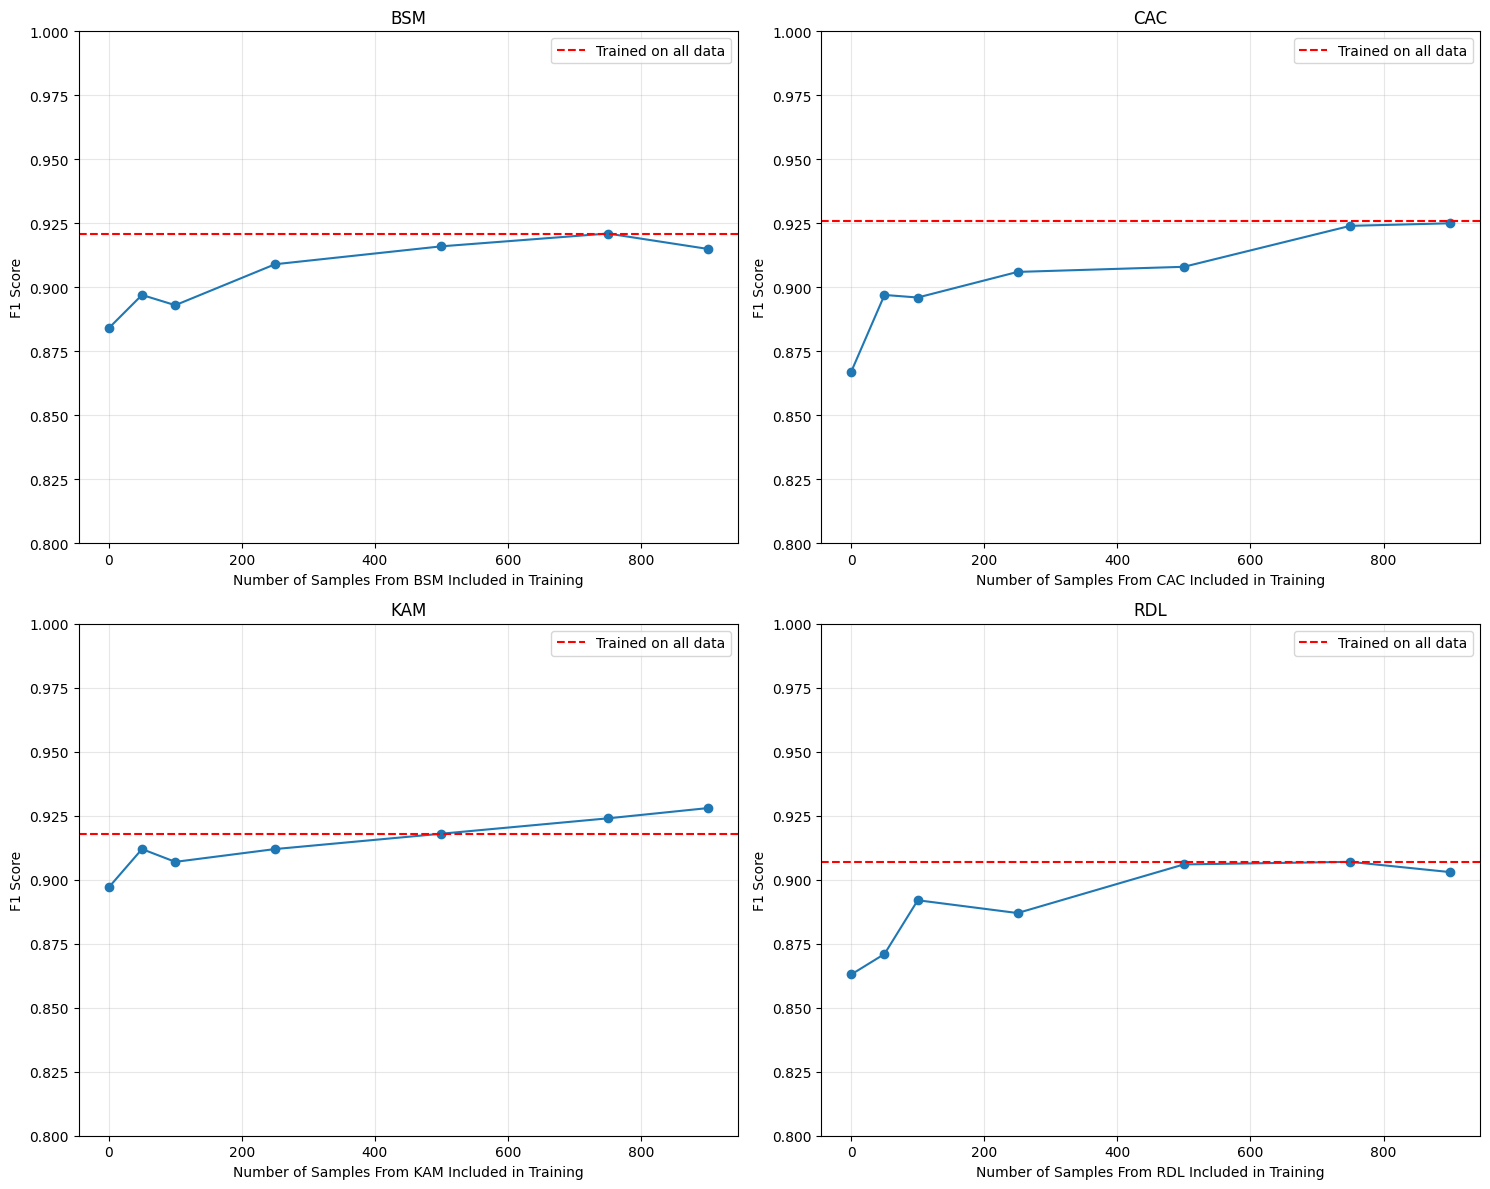

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Convert all site columns to float
for site in ['BSM', 'CAC', 'KAM', 'RDL']:
    plot_df[site] = plot_df[site].astype(float)

# Get the baseline performance from All_sites
baseline_performance = table_filtered[table_filtered['run'] == 'All_sites_qat_8bit'].iloc[0]

for site in ['BSM', 'CAC', 'KAM', 'RDL']:
    baseline_performance[site] = float(baseline_performance[site])

print(baseline_performance)
# Create a figure with subplots for each site
sites = ['BSM', 'CAC', 'KAM', 'RDL']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, site in enumerate(sites):
    ax = axes[idx]
    
    # Get the baseline for this site
    baseline = baseline_performance[site]
    
    # Filter data for this site's leave-out experiments
    site_data = plot_df[plot_df['run'].str.contains(f'leave_{site}_out') & plot_df['run'].str.contains('8bit')]
    
    site_data = site_data.sort_values('sample_size')

    # Plot the performance line
    ax.plot(site_data['sample_size'], site_data[site], 'o-')
    
    # Add horizontal line for baseline
    ax.axhline(y=baseline, color='r', linestyle='--', label='Trained on all data')
    
    # Customize the plot
    # ax.set_title(f'Leave {site} Out Performance')
    ax.set_title(f'{site}')
    ax.set_xlabel(f'Number of Samples From {site} Included in Training')
    ax.set_ylabel('F1 Score')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set y-axis limits to be consistent
    ax.set_ylim(0.8, 1.0)

plt.tight_layout()
plt.show()